In [21]:
#!pip install networkx
#!pip install matplotlib
#!pip install qiskit
#!pip install pylatexenc
#!pip install qiskit_optimization

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
from scipy.optimize import minimize
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from qiskit.circuit import Gate
from qiskit import QuantumCircuit , QuantumRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter
import numpy as np

In [23]:
## auxiliary functions

def print_results(nodes , power , Method ):

    total_cost = 0.0
    i = 0

    print("Load requirement : " , load)
    print("There are ", len(nodes) , "nodes")
    print("Indiviual unit power specifics: ")
    for node in nodes:
        print("Node: ", (i+1) , " , cost : " , node.A , "+" , node.B , "*p +" , node.C , "p**2 , Min Capacity :" , node.maxCapacity , " , Max Capacity: " , node.maxCapacity)
        total_cost += node.A + node.B*power[i] + node.C * power[i]**2
        i +=1 

    print("power disribution results using %s optimizer :"%(Method))
    print(power)


    print("The total cost = %e $ "%(total_cost))

def quantum_solution_cost(G , p ,result , shotsin):
    
    task_price = 0.25 # price for submitting task to system (in dollars)

    pHGate = 0.0001 # price for a single Hadamard  gate (in dollars)
    pZrot = 0.00003 # price for a single Z rotation (in dollars)
    pXrot = 0.00008 # price for a single X rotation (in dollars)

    price_per_shot = len(G.nodes()) * p * ( 4.0 *  pZrot +  pHGate + pXrot)

    Optim_evals = result.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.
    Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was
    # applied to the hardware.

    return (Optim_evals * shotsin * price_per_shot) + task_price

def compute_power(G , quc , params ,backend, shotsin,seed , method='Nelder-Mead'):
    

    expectation = quc.get_expectation(G, params ,backend, shotsin,seed)

    result = minimize(expectation,  params,options=options,method=method)
    if result.success:
        qc_res = quc.create_qaoa_circ(G, result.x )
        counts = backend.run(qc_res, seed_simulator=seed,shots = shotsin).result().get_counts()
        return [result , qc_res , counts]
    else:
        raise ValueError(result.message)


# Unit commitment Problem 

Unit commitment(UC) problem is a fundamental nonlinear non-convex NP-hard optimization problem which makes finding optimal solution difficult. The problem is usually modeled as a mixed-integer programming. The objective of UC problem is to achieve a common target given a set of generating units  subject to  a set of constraints.

The importance of the problem is reflected on the large different approaches suggested to solve the problem which requires fast decisions. Quantum computers may provide and advantage in this case.


## Problem Statement

The problem of Unit Commitment deals with what generators should be turned on/off and when depending on the demand so as to minimize costs.

 The main setup is as follows. We have a power grid with various power generation units(nodes) that are connected by transmission lines. For simplicity, we assume that we have a set of nodes with one load. The transmission costs is identical(we set the edge weight to unitary). To simplify the problem even furhter, we only consider one time step. Each node has a set of physical characterisctis: 
 
 A: fixed cost of the unit when it is turned on regardless of the power level.
 
 B: linear cost based on the power level.
 
 C: quandratic cost based on the power level.
 
 Total cost per unit: $C(P) = A + B*P + C* P^2$ where $P$ is the allocatated power to the unit. Classical methods are used to find this parameter like economic dispatch.  The total cost is  the sum of the costs of the units that are on.

 
 
 $P_{min}$: minimum generation limit.
 
 $P_{max}$: maximum generation limit.
 
There are many other operational parameters that can be added easily. For simplicity, we consider these. Fig. 1 demonstrates two ways that the load of a 4-unit system could be met while keeping within each unit’s
constraints, and gives the cost of each configuration [[1]](https://arxiv.org/abs/2110.12624).


![alt text](./images/uc.jpg "ref[]")



Thus the  variant we are dealing with can be formulated as the following binary problem:

$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}(y_i(A_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} P_i = L \\
& P_{min,i}  \leq P_i y_i \leq P_{max,i}\\
\end{aligned}
$$

Here, $y_i$ is a binary variable representing the state of the i-th generator ; 1 if on, 0 if
off. $A_i,B_i , C_i$ are constants ,  $P_i  \in \mathbb{R}$. $L$ is the load.

Following [[1]](https://arxiv.org/abs/2110.12624), we convert the constrained equation above into unconstrained one adding some penalty terms:


$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}((A_i*y_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} \lambda_1 * y_i(P_i -L )^{2} \\
&  \lambda_2 * (P_i -  s_{1,i} -  P_{min,i}*y_i)^{2} \\
&  \lambda_3 * (P_i +  s_{2,i} -  P_{max,i}*y_i)^{2} \\
\end{aligned}
$$

where $\lambda_1 , \lambda_2 , \lambda_3$ are some empirical constant , $s_{1,i} ,s_{2,i}$ are some penalty terms found by some classical optimizer.

Thus, our problem is to find the allocated power $p_i$ on each unit (at a certain time) such that the constraints above are satisfied. We use QAOA to determine whether the generating unit is on/off and the classicat optimizer to find the allocated power $p_i$. The classical optimizer is also used to estimate the $\gamma , \beta , s_1$ and $s_2$ values. The classical optimizer we use is the  SciPy’s optimize
package with  different optimization methods.


## Algorithm overview

We use QAOA to handle the problem of whether the unit is one or off and classical optimzer to handle the continuous variables $\gamma_{j}$ , $\beta_{j}$ and $P_{i}$ for $j = 1,2,...,p$ , for $i = 1,2,...,n$ where $n$ is the number of generating units and $p$ is the depth of the circuit. Our main task then would be to construct the cost layer( problem Hamiltonian ). For mixing Hamiltonian,  We will just use the default mixer layer with $R_X$ gates.

Let the input bitstring represent $y$. The i-th qubit  will represent whether the i-th generator is on (|1⟩) or off (|0⟩). The function of a cost layer  is to take this input state and add a phase to it, with the phase angle being the cost of the input state times some $\gamma_{i}$.

We need convert  binary variables $y_i \in \{0, 1\}$ to $z_i \in \{+1, −1\}$  by using the transformation $z_i = 2y_i − 1$ to comply with the standard form for QUBOs solved by QAOA.

[These Cost and Mixing Hamiltonian steps are repeated $P$ times before terminating measurements on each qubit.]

The problem Hamiltonian specific to the above problem is:

$$
\begin{aligned}
H_p & = Z_0 \otimes I_1 \otimes I_2 \otimes I_3 + I_0 \otimes Z_1 \otimes I_2 \otimes I_3  + I_0 \otimes I_1 \otimes Z_2 \otimes I_3 + I_0 \otimes I_1 \otimes I_2 \otimes Z_3 \\
U(H_p) &= e^{-i\gamma H_p} = e^{-i\gamma Z_0}e^{-i\gamma Z_1}e^{-i\gamma Z_2}e^{-i\gamma Z_3}
\end{aligned}
$$

In [24]:

class Node:

    def __init__(self, A, B, C, minCapacity , maxCapacity):
        self.A = A
        self.B = B
        self.C = C
        self.minCapacity = minCapacity
        self.maxCapacity = maxCapacity
        
    def cost(self , p):
        #### there are violations of these constraints. Either there is something wrong or penalities are not enough
        #assert p >= self.minCapacity , "power should be greater than minimum power"
        #assert p <= self.maxCapacity, "power should be smaller than maximum power"
        
        return (self.A + self.B*p + self.C * p**2)
    

nodes  = []
### using the  example above
nodes.append(Node(30,25,100 , 100 , 300))
nodes.append(Node(50,10,80  , 100 , 300))
nodes.append(Node(20,30,120 , 500 , 900))
nodes.append(Node(20,20,70  , 0 , 900))
random.seed(1)

nqubits = len(nodes)


#G.add_nodes_from([i for i in range(nqubits)])

### initial power values
weights_nodes = []

G = nx.Graph()

for nn in range(0,len(nodes)):
    #weights_nodes.append( -1.0 *nodes[nn].cost(power[nn])) ## node weights are -1 
    weights_nodes.append( -1.0 ) ## node weights are the 
    G.add_nodes_from([(nn,{'weight':  weights_nodes[nn]})])
    for nn2 in range(0,len(nodes)):
         G.add_edges_from([(nn, nn2,{'weight': 0})])  ### weights are zero since there is no transmission cost???
    

### The Initial State

We use the default initial state of the QAOA

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$


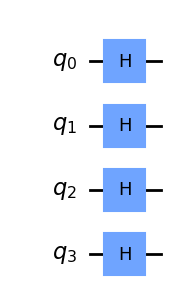

In [25]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

### The Mixing Unitary

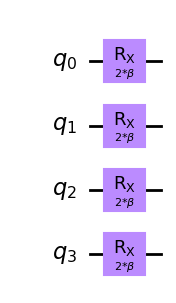

In [26]:


beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw("mpl")

### The Problem Unitary

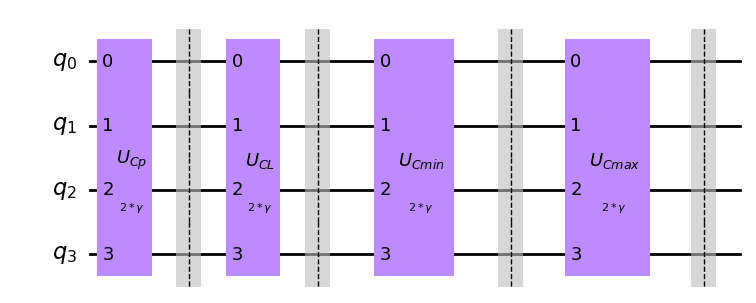

In [27]:
    ## all this represent cost layer
gamma = Parameter("$ 2* \\gamma$")
qc_p = QuantumCircuit(nqubits)
qr = QuantumRegister(nqubits, 'q')

Cp = Gate(name="$U_{Cp}$", num_qubits=4, params=[gamma])
CL = Gate(name="$U_{CL}$", num_qubits=4, params=[gamma])
Cmin = Gate(name="$U_{Cmin}$", num_qubits=4, params=[gamma])
Cmax = Gate(name="$U_{Cmax}$", num_qubits=4, params=[gamma])

qc_p.append(Cp , qr)
qc_p.barrier()

qc_p.append(CL , qr)
qc_p.barrier()

qc_p.append(Cmin , qr)
qc_p.barrier()

qc_p.append(Cmax , qr)
qc_p.barrier()

qc_p.draw("mpl")

where $Cp$ corresponds to the first term of the cost function above, $CL$ , $Cmin$ and $Cmax$ correspond to the following constraints. 

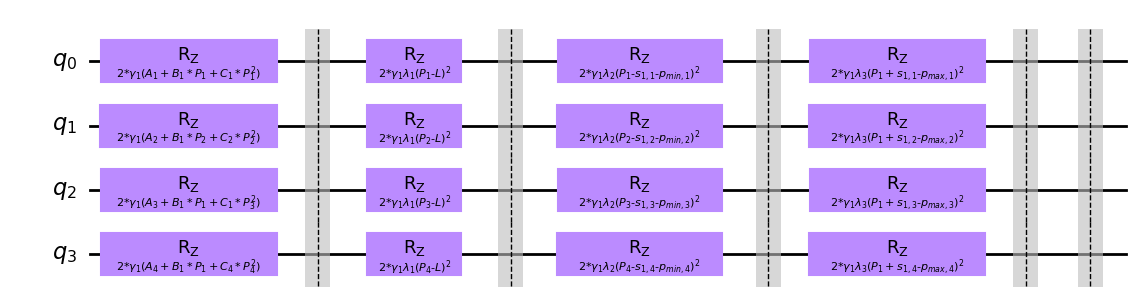

In [28]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_1*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_1*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_1*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])
qc_p.barrier()
qc_p.barrier()


qc_p.draw("mpl")

## Putting it all together


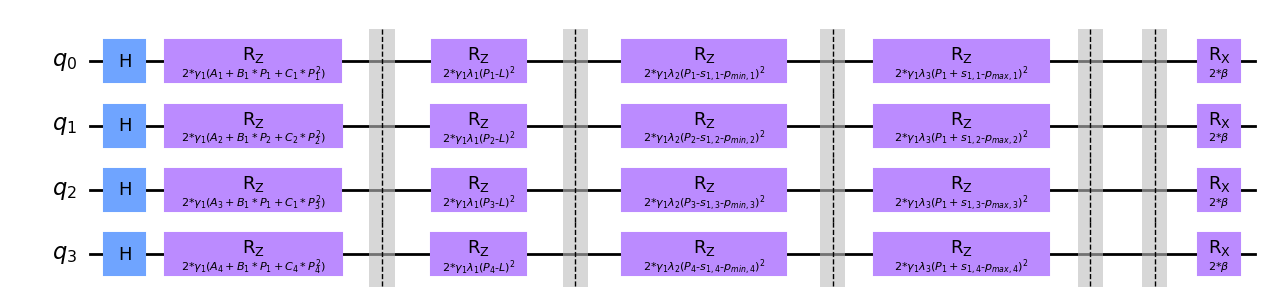

In [29]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().draw("mpl")

Or in more detail

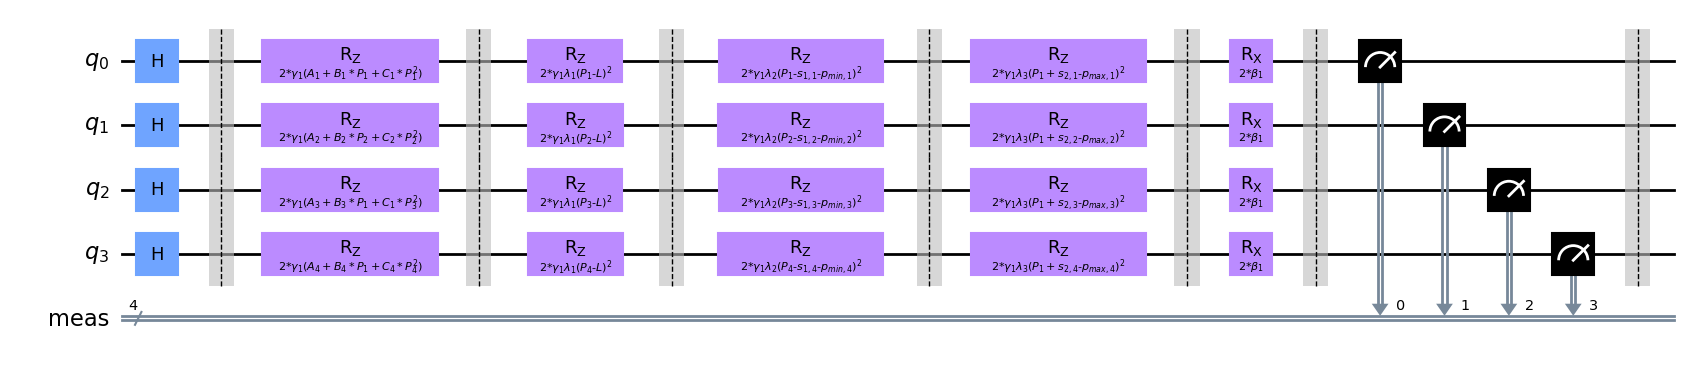

In [30]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

for i in range(0, nqubits):
    qc_p.h(i)


qc_p.barrier()

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_2*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_3*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_4*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])

qc_p.barrier()

# Add the first mixer layer

beta1 = Parameter("$\\beta_1$")


qc_p.rx(2 *beta1, qr)


qc_p.measure_all()

qc_p.barrier()


qc_p.draw("mpl")

# QAOA Implementation

In [31]:
class QUCProblem:
    
    def __init__(self , nodes , lambda1 ,  lambda2 , lambda3, load=1000 ,p=1):
        
        self.nodes = nodes
        self.load = load
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.p = p  ## depth of the circuit
        
    def maxcut_obj(self , x, G):

        obj = 0
        for i, j in G.edges():
            if x[i] == x[j] and x[i] == "1":
                obj += G.edges[(i,j)]["weight"]

        for i in G.nodes():
            if x[i] == "1":
                obj += G.nodes[i]["weight"]
        return obj


    def compute_expectation(self , counts, G):

        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():

            obj = self.maxcut_obj(bitstring, G)
            avg += obj * count
            sum_count += count

        return avg/sum_count


    def create_qaoa_circ(self , G, params):

        nqubits = len(G.nodes())
        qc = QuantumCircuit(nqubits)
        
        theta  =  params[:(p *2)]                          
        power = params[(p *2):nqubits+(p *2)]  
        s1 = params[nqubits+(p *2):2*(nqubits+p)] 
        s2 = params[-nqubits:] 
        
        gamma = theta[:self.p ]
        beta = theta[-self.p :]

        # initial_state
        for i in range(0, nqubits):
            qc.h(i)
        qc.barrier()
        for irep in range(0, self.p):

            # problem unitary
            for nod in range(0, nqubits):
                unit_cost =  self.nodes[nod].A +  self.nodes[nod].B* power[nod] + \
                self.nodes[nod].C*power[nod]**2
                qc.rz(2 * gamma[irep]*unit_cost, nod)
                
                ### these corresponds to the constraint lambda_1(P_1 - L)^{2}
                qc.rz(2 * gamma[irep]* (lambda1[nod]*(power[nod] - self.load)**2), nod)
                
                ### these corresponds to the constraint lambda_2(P_1 - s_{1,1} - p_{min,1})^{2}
                qc.rz(2 * gamma[irep]* (lambda2[nod]*(power[nod] - s1[nod] - self.nodes[nod].minCapacity)**2), nod)
                
                ### these corresponds to the constraint lambda_3(P_1 + s_{2,1} - p_{max,1})^{2}
                qc.rz(2 * gamma[irep]* (lambda2[nod]*(power[nod] + s2[nod] - self.nodes[nod].maxCapacity)**2), nod)
                
            qc.barrier()

            # mixer unitary
            for i in range(0, nqubits):
                qc.rx(2 * beta[irep], i)

        qc.measure_all()

        return qc

    # Finally we write a function that executes the circuit on the chosen backend
    def get_expectation(self , G, params , backend, shotsin,seed):
        
        def execute_circ(params):
            
            qc = self.create_qaoa_circ(G, params)

            # We need this step if we want to run on hardware.# tqc = qiskit.compiler.transpile(qc,backend)
            tqc = qc
            #print(theta)
            counts = backend.run(tqc, seed_simulator=seed,shots = shotsin).result().get_counts()

            return self.compute_expectation(counts, G)

        return execute_circ

In [32]:
  ####  initalzing te mode . initial values are important !
nqubits = len(G.nodes())
backend = Aer.get_backend('qasm_simulator')

load = 1000.0
seed = 5

p = 3
theta = [1.0]* 2 * p  ## initial values of gamma and beta

##using initial power disribution
power = [np.ceil(load /nqubits)] * nqubits   ### initally, the load is distributed equally between the units

##using initial power disribution


s1 = [0.0] * nqubits
s2 = [0.0] * nqubits
## these variables are penalizing constraints and are set emprically
lambda1  = [1.0]*nqubits
lambda2  = [1.0]*nqubits
lambda3  = [1.0]*nqubits

quc = QUCProblem(nodes , lambda1 , lambda2 , lambda3 , load = load , p=p)

# Number of quantum measurements each time the quantum circuit is called
shotsin = 2000
maxiter = 10000


options = {'maxiter': maxiter}
backend = Aer.get_backend('aer_simulator')
params =  np.concatenate( [theta , power , s1 , s2] , axis=0 )                         

#res = minimize(expectation,[theta0 , power , s1 , s2],options=options,method='Nelder-Mead')


## Analyzing the result

As discussed previously, the job of the classical computer in QAOA is to optimize the variational parameters: $\gamma = (\gamma_1 , \gamma_2, ..., \gamma_P )$ and $\beta = (\beta_1 , \beta_2 , ..., \beta_P )$ where
$\gamma_i , \beta_i \in [0, 2\pi)$. We also use the classical optimizer to find the  individual unit power
values that minimize the cost function.  Specifically using the Nelder-Mead algorithm [[3]](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html)  from SciPy’s optimize package  with the $\gamma, \beta, p, s$ as the arguments.  For each iteration of  the classical minimizer,
we simulate a quantum processor to execute QAOA. This returns a probability distribution of the optimal combinations of units to be used, given the power values that the classical minimizer has designated to each unit.


### The total power cost and the power distribution results using different classical optimizers as well as quantum solution cost

Load requirement :  1000.0
There are  4 nodes
Indiviual unit power specifics: 
Node:  1  , cost :  30 + 25 *p + 100 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  2  , cost :  50 + 10 *p + 80 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  3  , cost :  20 + 30 *p + 120 p**2 , Min Capacity : 900  , Max Capacity:  900
Node:  4  , cost :  20 + 20 *p + 70 p**2 , Min Capacity : 900  , Max Capacity:  900
power disribution results using Nelder-Mead optimizer :
[247.75919154 252.57191564 252.01099356 252.74839061]
The total cost = 2.335619e+07 $ 
The estimated cost of quantum solution is = $6912.250000000001


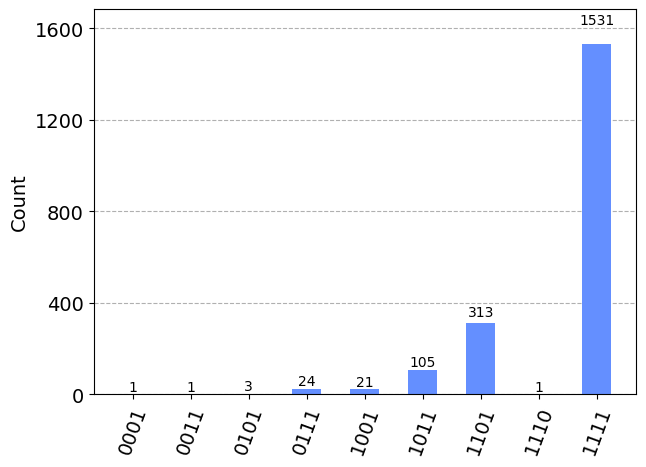

In [33]:
[result , qc_res , counts]  = compute_power(G , quc , params ,backend, shotsin,seed , method='Nelder-Mead')
power = result.x[(p *2):nqubits+(p *2)]  
print_results(nodes , power , 'Nelder-Mead')
print("The estimated cost of quantum solution is = $"+str(quantum_solution_cost(G , p ,result , shotsin)))
plot_histogram(counts)

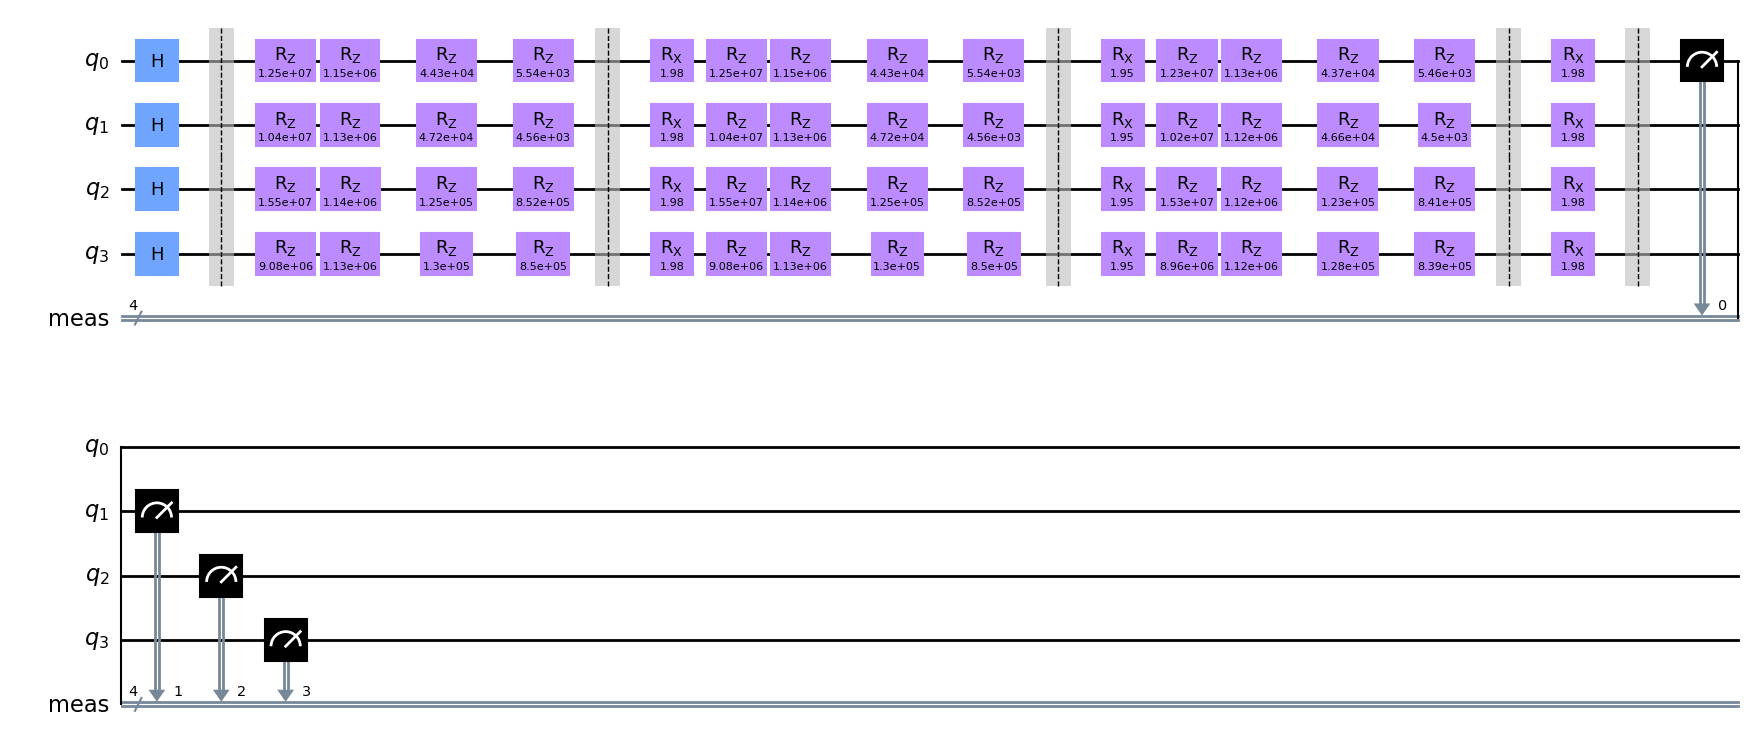

In [34]:
qc_res.draw("mpl")


Load requirement :  1000.0
There are  4 nodes
Indiviual unit power specifics: 
Node:  1  , cost :  30 + 25 *p + 100 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  2  , cost :  50 + 10 *p + 80 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  3  , cost :  20 + 30 *p + 120 p**2 , Min Capacity : 900  , Max Capacity:  900
Node:  4  , cost :  20 + 20 *p + 70 p**2 , Min Capacity : 900  , Max Capacity:  900
power disribution results using cobyla optimizer :
[251.04650367 251.0236954  251.02944221 249.91948219]
The total cost = 2.329898e+07 $ 
The estimated cost of quantum solution is = $1101.8500000000001


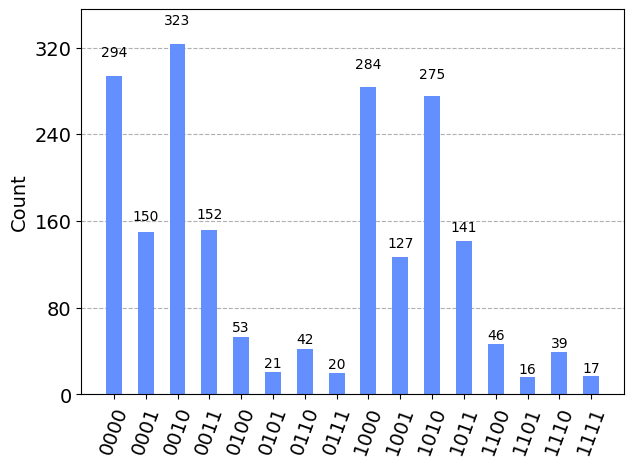

In [35]:
[result , qc_res , counts] = compute_power(G , quc , params ,backend, shotsin,seed , method='COBYLA')
power = result.x[(p *2):nqubits+(p *2)]  
print_results(nodes , power , 'cobyla')
print("The estimated cost of quantum solution is = $"+str(quantum_solution_cost(G , p ,result , shotsin)))
plot_histogram(counts)


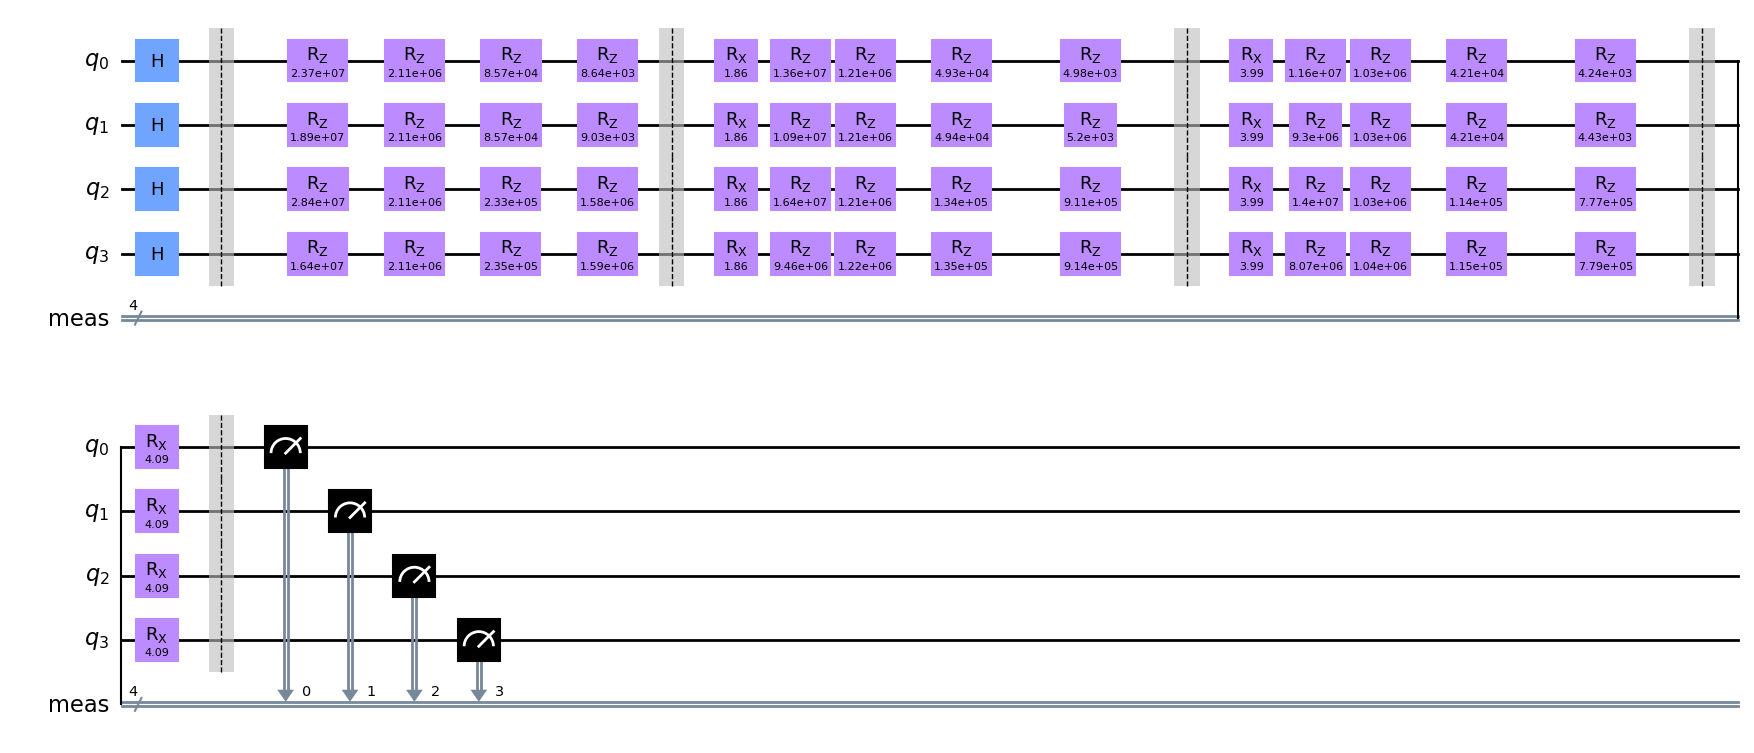

In [36]:
qc_res.draw("mpl")


Load requirement :  1000.0
There are  4 nodes
Indiviual unit power specifics: 
Node:  1  , cost :  30 + 25 *p + 100 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  2  , cost :  50 + 10 *p + 80 p**2 , Min Capacity : 300  , Max Capacity:  300
Node:  3  , cost :  20 + 30 *p + 120 p**2 , Min Capacity : 900  , Max Capacity:  900
Node:  4  , cost :  20 + 20 *p + 70 p**2 , Min Capacity : 900  , Max Capacity:  900
power disribution results using slsqp optimizer :
[ 1.33953632e+08  9.55194999e+04  1.54510301e+08 -1.19537063e+08]
The total cost = 5.659408e+18 $ 
The estimated cost of quantum solution is = $17323.45


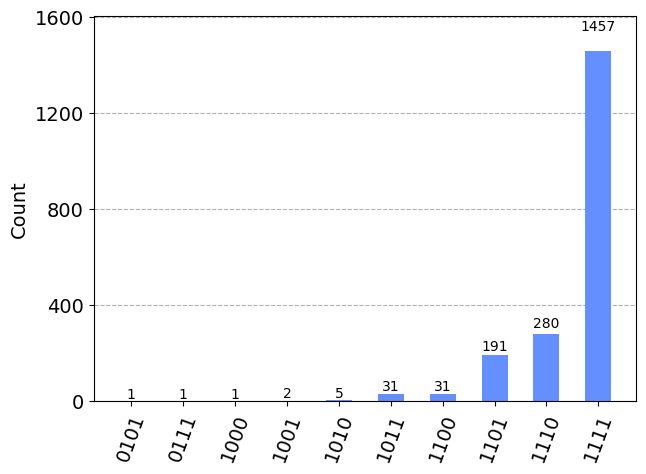

In [37]:
[result , qc_res , counts] = compute_power(G , quc , params ,backend, shotsin,seed , method='SLSQP')
power = result.x[(p *2):nqubits+(p *2)]  
print_results(nodes , power , 'slsqp')
print("The estimated cost of quantum solution is = $"+str(quantum_solution_cost(G , p ,result , shotsin)))
plot_histogram(counts)


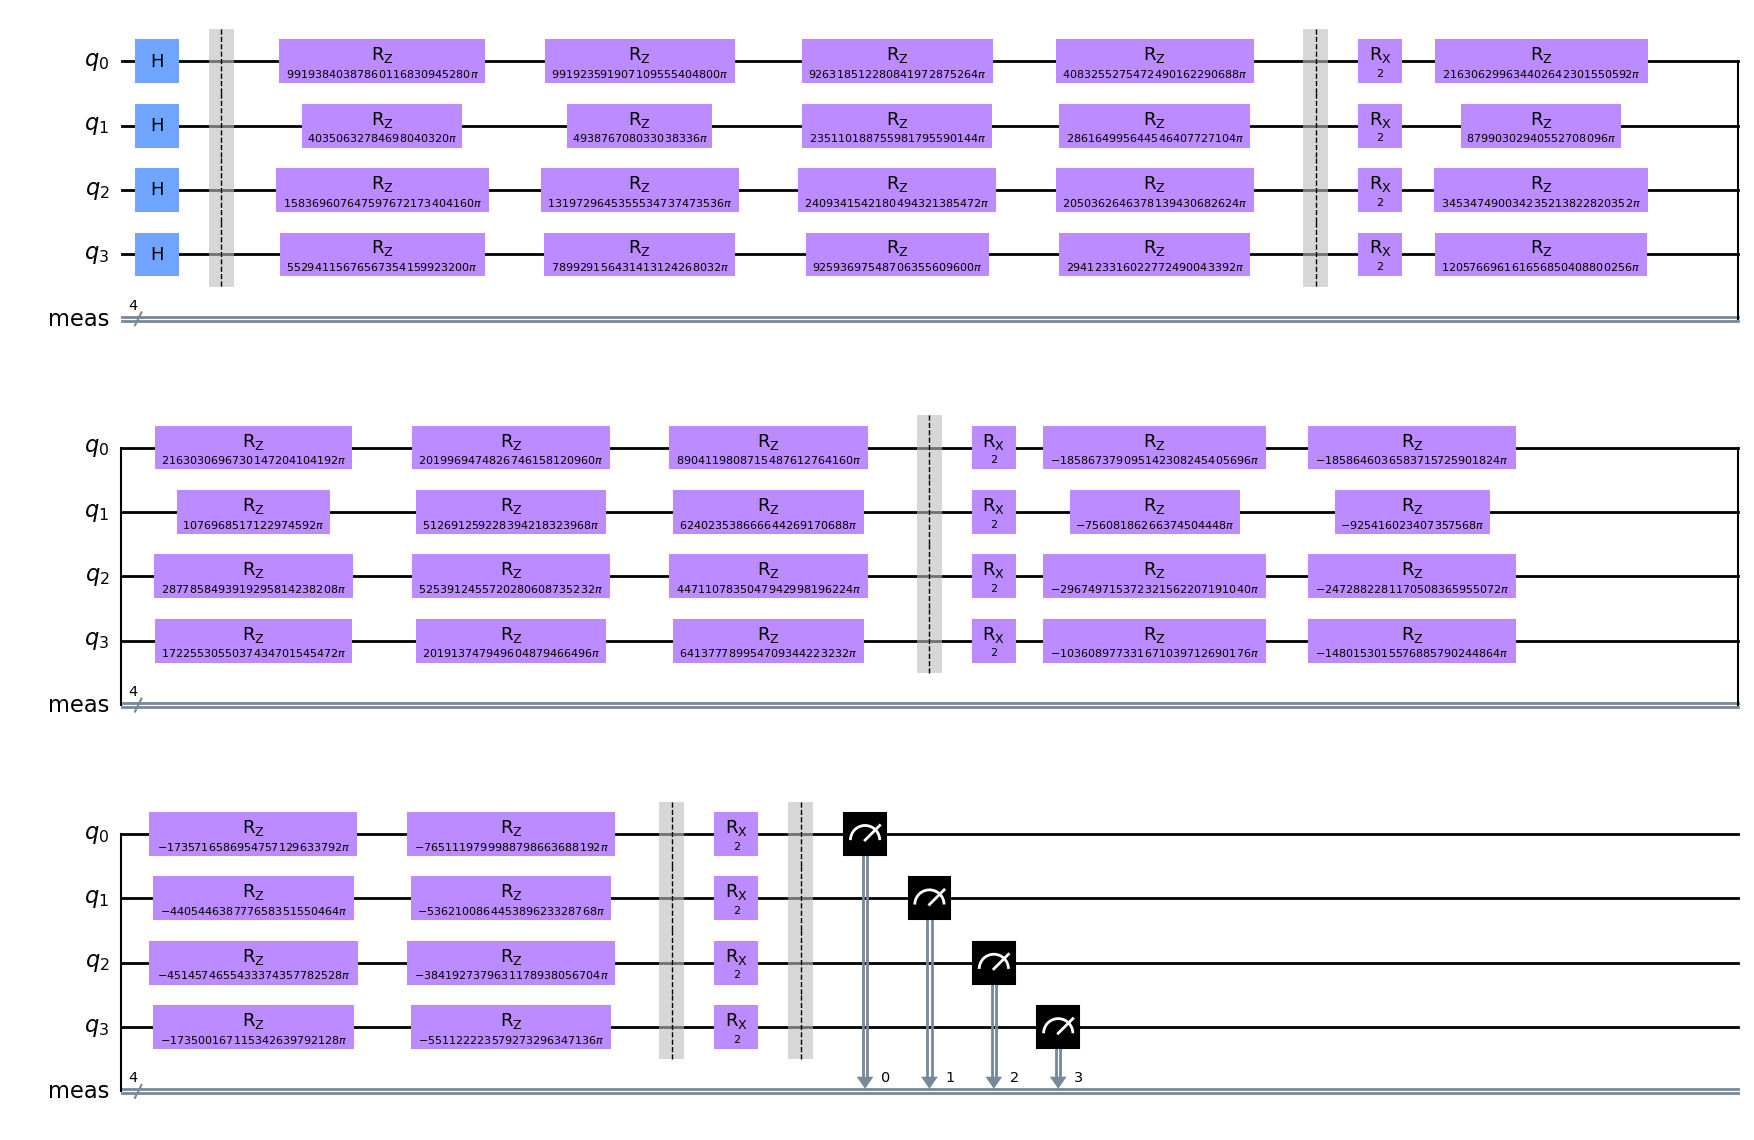

In [38]:
qc_res.draw("mpl")


### Exact Solution

In this section we find the exact ground state of the above Hamiltonian by finding the eigenstates with the lowest energy. This only works for a small number of qubits, due to the exponential scaling of the computational complexity, but it is useful for benchmarking the QAOA algorithm that we will describe below. 

In [39]:
import numpy as np
import scipy.sparse.linalg as sla
import copy

edges = np.zeros((len(G.edges()),2),dtype=int)
we = np.zeros(len(G.edges()),dtype=float)
iter = 0
for x in G.edges():
    edges[iter,0] = x[0]
    edges[iter,1] = x[1]
    we[iter] = G.edges[x]["weight"]
    iter = iter + 1

wn = np.zeros(len(G.nodes()),dtype=float)
iter = 0
for i in G.nodes():
    wn[iter] = G.nodes[i]["weight"]
    iter = iter + 1

def TensorProd(A):

    out = np.kron(A[0],A[1])
    for oo in range(2,len(A)):
        out = np.kron(out,A[oo])

    return out

sz = [[1.0,0.0],[0.0,0.0]]

A0 = []
for n in range(0,len(nodes)):
    A0.append(np.eye(2))

out = TensorProd(A0)

Ham = np.zeros((np.power(2,len(nodes)),np.power(2,len(nodes))),dtype=float)
for p in range(0,len(nodes)):
    A = copy.deepcopy(A0)
    A[p] = sz
    Ham += wn[p] * TensorProd(A)

for p in range(0,len(G.edges())):
    A = copy.deepcopy(A0)
    A[edges[p][0]] = sz
    A[edges[p][1]] = sz
    Ham += we[p] * TensorProd(A)

Egs_exact, V = sla.eigs(Ham, 1, which='SR')

print("The cost of the optimal solution is "+str(np.real(Egs_exact[0])))

The cost of the optimal solution is -3.9999999999999982


### Larger Example (TODO)

![alt text](./images/table1.jpg "ref[]")


# UC as a Quadratic Program (TODO)



In [40]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

### Higher values of $p$


Theoretically , QAOA can recover better energy values of the cost Hamiltonian with  larger depth $p$ values. At infinte ciruit depth, QAOA can reach the quantum adiapatic algorithm which solves the problem[[2]](https://arxiv.org/abs/quant-ph/0104129)
$$
\lim\limits_{p \to \inf} M_p = C_{max}.
$$

where $C_{max}$ is the maximal cost function value. 

However, this requires infinte circuit depth. We are using small values of $p$ to reduce gate count and minimize error resulting from the short lifetime of qubits and large number of QAOA parameters.

We will use Nelder-Mead optimization method of scipy method for examing higher values of QAOA circuit depth.

In [41]:
powerList = []
qCircuitCost = []
countList = [] 
p = 3
for pTemp in range(1,p):
    quc = QUCProblem(nodes , lambda1 , lambda2 , lambda3 , load = load , p=pTemp)

    [result , qc_res , counts]  = compute_power(G , quc , params ,backend, shotsin,seed , method='Nelder-Mead')
    powerList.append(result.x[(p *2):nqubits+(p *2)])  
    qCircuitCost.append(quantum_solution_cost(G , p ,result , shotsin))
    countList.append(counts)

In [42]:
powerList

[array([250.7019394 , 251.79364254, 251.75691718, 248.60603111]),
 array([250.34618893, 250.34942056, 250.34768242, 250.34798885])]

In [43]:
pTotal = []
pTotalCost = []
for j in range(len(powerList)):
    tempSum =0
    pCost = 0
    for i in range(len(powerList[j])):
        tempSum +=powerList[j][i]
        pCost +=nodes[i].cost(powerList[j][i])
    pTotal.append(tempSum)
    pTotalCost.append(pCost)
    
history = {"power generated": pTotal, "quamtum cost":qCircuitCost , "Total Power Cost":pTotalCost}


Final cost power generated: 1.001391e+03
Final cost quamtum cost: 6.005050e+03
Final cost Total Power Cost: 2.321077e+07


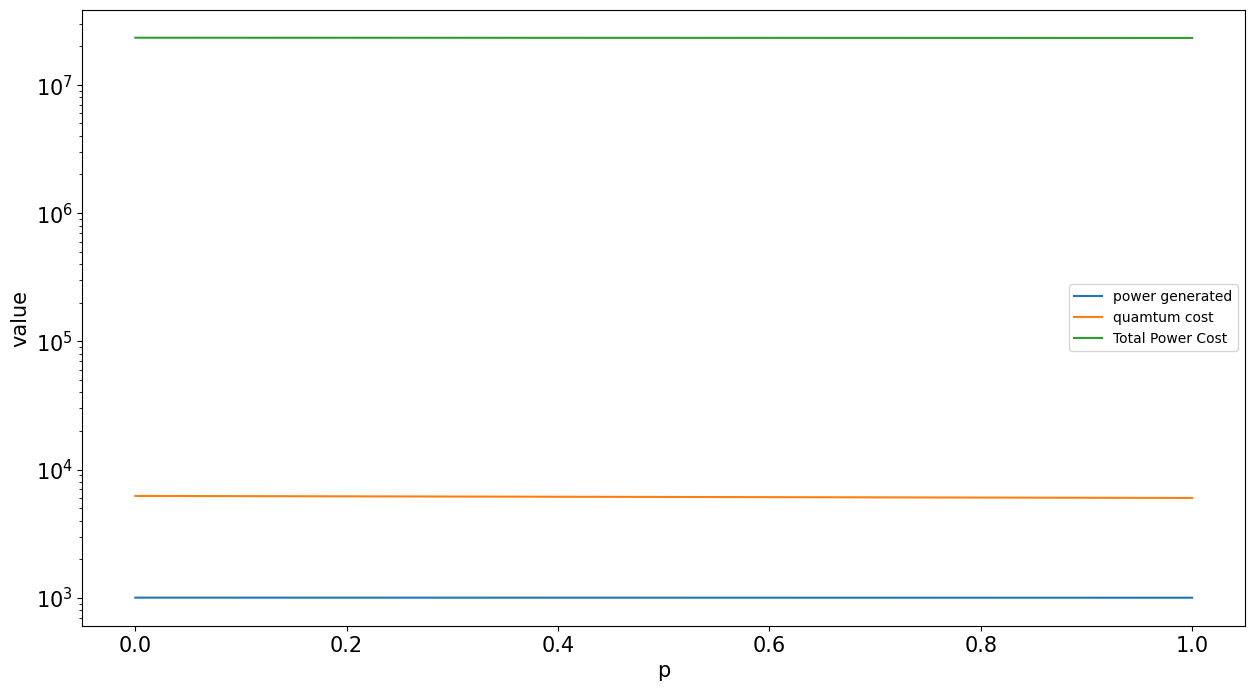

In [44]:
def plot_history(history):
    
    fig, ax = plt.subplots()
    fig.set_size_inches([15,8])
    for key in history:
        print("Final cost %s: %e" % (key, history[key][-1]))
        ax.semilogy(history[key], label=key)
    ax.set_xlabel("p", fontsize=15)
    ax.set_ylabel("value", fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend()
    plt.show()

plot_history(history)

# Conclusion

We can summerize results as follwos:

- Number of gates required is $O(6N*P)$  where $N$ is the number of nodes and $P$ is the depth of the circuit.
- Nelder-Mead and COBYLA give best results with Nelder-Mead method slightly better.

## References<a id="references"></a>
[[1] Adapting Quantum Approximation Optimization Algorithm (QAOA) for Unit Commitment
](https://arxiv.org/abs/2110.12624) by Samantha Koretsky et al.

[[2]“A quantum adiabatic evolution algorithm applied to random instances of an NP-complete problem”](https://arxiv.org/abs/quant-ph/0104129) by Edward Farhi et al.In: Science 292.5516
(2001), pp. 472–475.

[[3]The SciPy community.minimize(method=Nelder-Mead)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html)


In [18]:
from qiskit.primitives import Sampler
from qiskit.algorithms import AmplitudeEstimation
from qiskit.algorithms import EstimationProblem
import numpy as np
from qiskit.circuit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit import transpile



In [12]:

class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k


In [13]:
p = 0.2

A = BernoulliA(p)
Q = BernoulliQ(p)

In [14]:

sampler = Sampler()

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)


problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

ae_result = ae.estimate(problem)


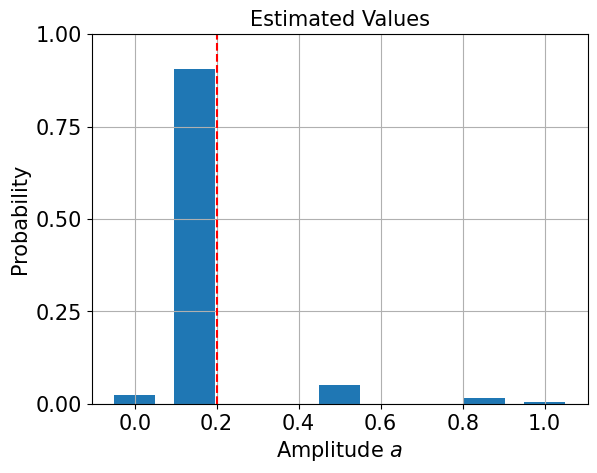

In [15]:

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [16]:
print("Interpolated MLE estimator:", ae_result.mle)


Interpolated MLE estimator: 0.19999999497921261


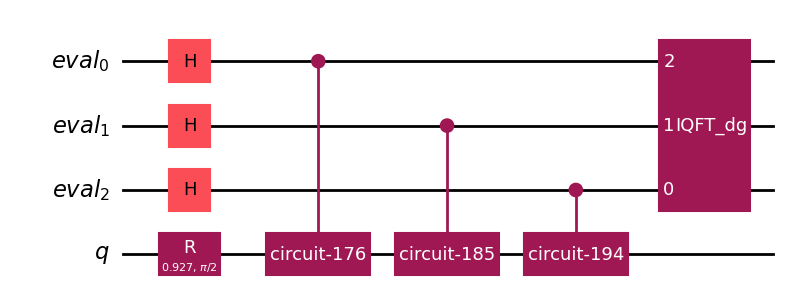

In [17]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!

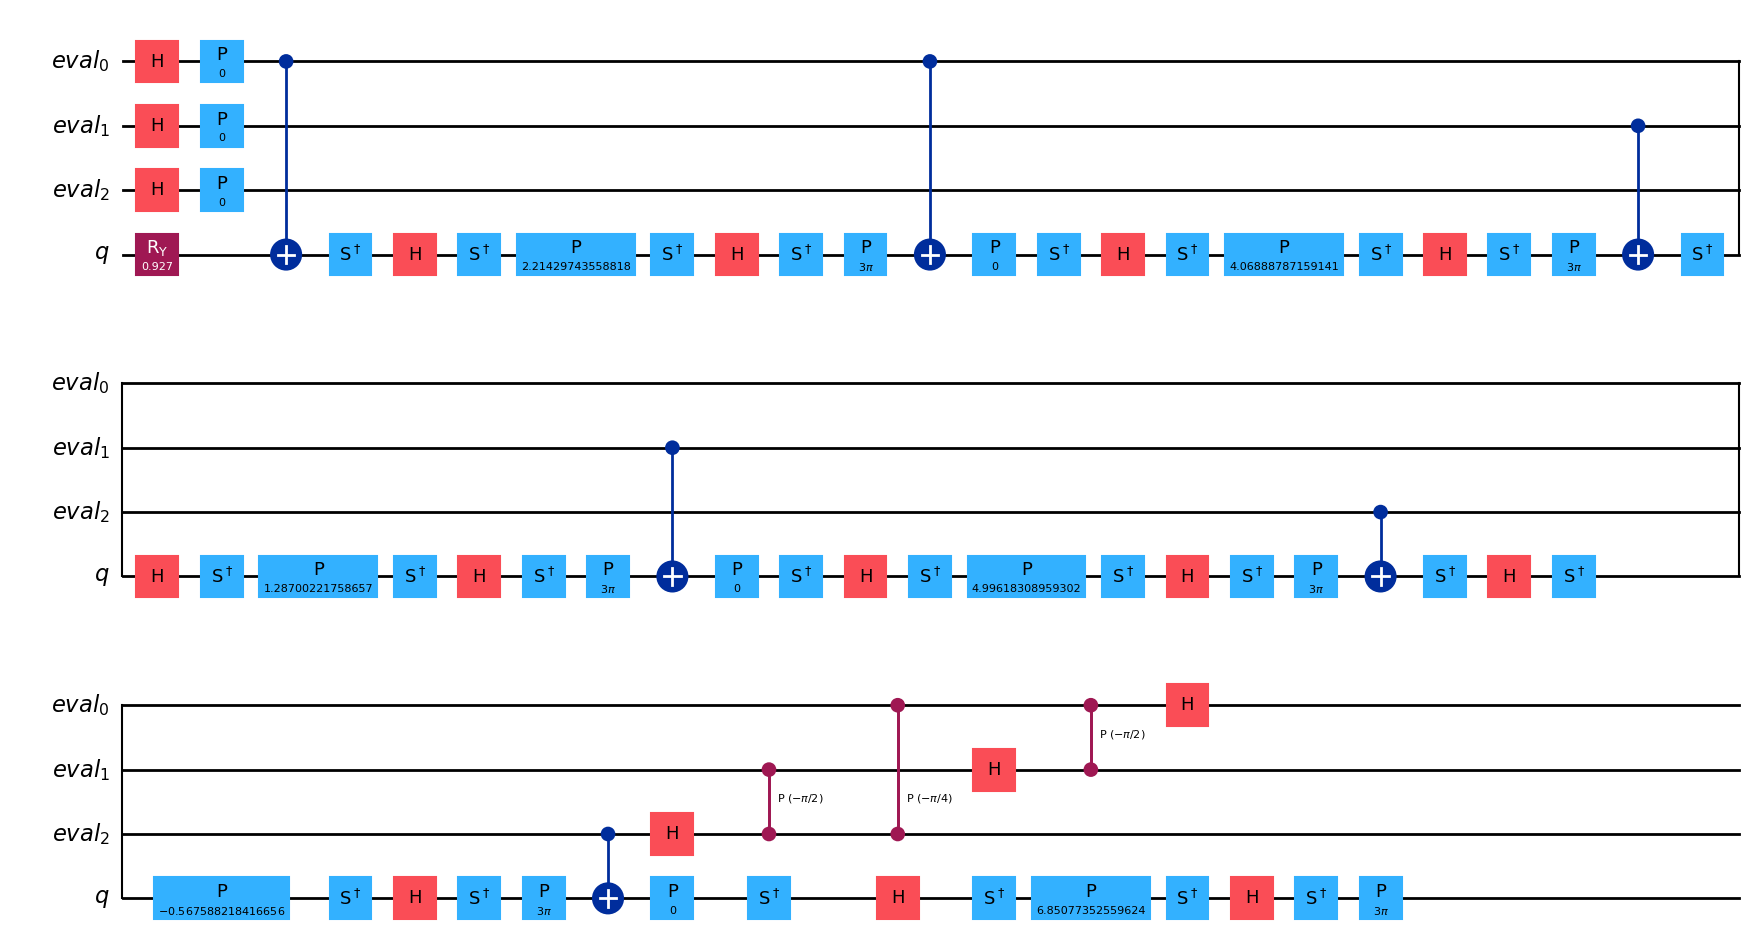

In [19]:


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")
